In [1]:
!pip install category_encoders
!pip install gensim
!pip install --upgrade tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


In [2]:
import json
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

import category_encoders as ce
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder as ohe


from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from keras.regularizers import l2

import itertools



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
#with open("train.json") as f_train, open("test.json") as f_test:
    #train = json.load(f_train)
    #test = json.load(f_test)
train = pd.read_json("train.json")
test = pd.read_json("test.json")

In [4]:
####################### VENUE PROCESSING #########################
#BIN/OHE ENCODING PRODUCED 
venue_test=[]
for i in range(len(test)):
    if(test.loc[i]['venue'] != '' and test.loc[i]['venue'] not in venue_test):
        venue_test.append(test.loc[i]['venue'])
venue_test.sort()

venue_train=[]
for i in range(len(train)):
    if(train.loc[i]['venue'] != '' and train.loc[i]['venue'] not in venue_train):
        venue_train.append(train.loc[i]['venue'])
venue_train.sort()

venue_full_set = set(venue_test+venue_train+[999])
venue_str = [str(x) for x in venue_full_set]

##################
bin_encoder = ce.BinaryEncoder(return_df = False)
venue_bin = bin_encoder.fit_transform(venue_str)

oh_encoder = ohe()
venue_str_2d = [[str(x)] for x in venue_full_set]
venue_ohe = oh_encoder.fit_transform(venue_str_2d).toarray()
##################

venue_bin_dict = {list(venue_full_set)[i]:venue_bin[i] for i in range(len(venue_full_set))}
venue_ohe_dict = {list(venue_full_set)[i]:venue_ohe[i] for i in range(len(venue_full_set))}

print(len(venue_bin_dict))
print(len(venue_ohe_dict))

465
465


In [5]:
####################### YEAR PROCESSING #########################
#BIN/OHE ENCODING PRODUCED

year_test=[]
for i in range(len(test)):
    if(test.loc[i]['year'] != '' and test.loc[i]['year'] not in year_test):
        year_test.append(test.loc[i]['year'])
year_test.sort()

year_train=[]
for i in range(len(train)):
    if(train.loc[i]['year'] != '' and train.loc[i]['year'] not in year_train):
        year_train.append(train.loc[i]['year'])
year_train.sort()

year_full_set = set(year_test+year_train)

year_str = [str(x) for x in year_full_set]

##################
bin_encoder = ce.BinaryEncoder(return_df = False)
year_bin = bin_encoder.fit_transform(year_str)

oh_encoder = ohe()
year_str_2d = [[str(x)] for x in year_full_set]
year_ohe = oh_encoder.fit_transform(year_str_2d).toarray()
##################

year_bin_dict = {list(year_full_set)[i]:year_bin[i] for i in range(len(year_full_set))}
year_ohe_dict = {list(year_full_set)[i]:year_ohe[i] for i in range(len(year_full_set))}

print(year_bin_dict)
print(year_ohe_dict)

{0: array([0, 0, 0, 0, 1]), 1: array([0, 0, 0, 1, 0]), 2: array([0, 0, 0, 1, 1]), 3: array([0, 0, 1, 0, 0]), 4: array([0, 0, 1, 0, 1]), 5: array([0, 0, 1, 1, 0]), 6: array([0, 0, 1, 1, 1]), 7: array([0, 1, 0, 0, 0]), 8: array([0, 1, 0, 0, 1]), 9: array([0, 1, 0, 1, 0]), 10: array([0, 1, 0, 1, 1]), 11: array([0, 1, 1, 0, 0]), 12: array([0, 1, 1, 0, 1]), 13: array([0, 1, 1, 1, 0]), 14: array([0, 1, 1, 1, 1]), 15: array([1, 0, 0, 0, 0]), 16: array([1, 0, 0, 0, 1]), 17: array([1, 0, 0, 1, 0]), 18: array([1, 0, 0, 1, 1]), 19: array([1, 0, 1, 0, 0])}
{0: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 1: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 2: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0.]), 3: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0.]), 4: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [6]:
####################### ABSTRACT PROCESSING /INPLACE #########################
#BOW ENCODED KEYWORDS

abstract_test = []
for i in range(len(test)):
    abstract_test.append(test.loc[i]['abstract'])

print(len(abstract_test))
#abstract_train = [y['abstract'] for _,y in train.items() for _ in y['author']]
abstract_train = []
for i in range(len(train)):
    #for j in range(len(train.loc[i]['authors'])):
        #if(train.loc[i]['authors'][j]<=100):
    abstract_train.append(train.loc[i]['abstract'])
        #break

abstract_test = [list(map(str,x)) for x in abstract_test]
abstract_train = [list(map(str,x)) for x in abstract_train]

abstract_test_iter = [" ".join(x) for x in abstract_test]
abstract_train_iter = [" ". join(x) for x in abstract_train]

abstract_full_iter = abstract_train_iter+abstract_test_iter

vectorizer = CountVectorizer(lowercase=False)

abstract_full_bow = vectorizer.fit_transform(abstract_full_iter)

abstract_train_bow = abstract_full_bow.toarray()[:48000]

print(abstract_train_bow.shape)

800
(26593, 4840)


In [7]:
####################### ABSTRACT #######################
######################### WORD2VEC GENERATOR #########################
#***************W2V PARAM TO BE FURTHER TUNED

abstract_full_list = abstract_test+abstract_train
abstract_full_set = set(tuple(row) for row in abstract_full_list)
w2v_model = Word2Vec(sentences=abstract_full_set, sg=0,hs=1,vector_size=512, window = 56)

abstract_train_w2v = []
for x in abstract_train:
    abstract_train_w2v.append([w2v_model.wv[x1] for x1 in x if (x1 in w2v_model.wv)])
    
    
#SUMMING UP AND STANDARDIZING
abstract_train_w2v_sum = [np.sum(x, axis=0) for x in abstract_train_w2v]
abstract_train_w2v_ar = np.asarray(abstract_train_w2v_sum)

#SCALING, USE MINMAX PRODUCES BETTER RESULTS WITH OHE
std_scaler = StandardScaler()
abstract_train_w2v_std_scaled = std_scaler.fit_transform(abstract_train_w2v_ar)

minmax_scaler = MinMaxScaler()
abstract_train_w2v_minmax_scaled = minmax_scaler.fit_transform(abstract_train_w2v_ar)

print(abstract_train_w2v_minmax_scaled.shape)


(25793, 512)


In [8]:
####################### TITLE PROCESSING /INPLACE #########################
#BOW ENCODED KEYWORDS

#title_test = [y['title'] for _,y in test.items()]
title_test = []
for i in range(len(test)):
    title_test.append(test.loc[i]['title'])
    
#title_train = [y['title'] for _,y in train.items() for _ in y['author']]
title_train = []
for i in range(len(train)):
    #for j in range(len(train.loc[i]['authors'])):
    #    if(train.loc[i]['authors'][j]<=100):
    title_train.append(train.loc[i]['title'])
     #       break

title_test = [list(map(str,x)) for x in title_test]
title_train = [list(map(str,x)) for x in title_train]

title_test_iter = [" ".join(x) for x in title_test]
title_train_iter = [" ". join(x) for x in title_train]

title_full_iter = title_train_iter+title_test_iter

vectorizer = CountVectorizer(lowercase=False)

title_full_bow = vectorizer.fit_transform(title_full_iter)

title_train_bow = title_full_bow.toarray()
title_train_bow.shape

(26593, 3473)

In [9]:
####################### TITLE #######################
######################### WORD2VEC GENERATOR #########################
#***************W2V PARAM TO BE FURTHER TUNED
# SETTING sg = 0 MEANS USING CBOW,  1 MEANS USING SKIP GRAM

title_full_list = title_test+title_train
title_full_set = set(tuple(row) for row in title_full_list)
w2v_model = Word2Vec(sentences=title_full_set, sg=0,hs=1,vector_size=512, window = 56)

title_train_w2v = []
for x in title_train:
    title_train_w2v.append([w2v_model.wv[x1] for x1 in x if (x1 in w2v_model.wv)])
    
#SUMMING UP AND STANDARDIZING
title_train_w2v_sum = [np.sum(x, axis=0) for x in title_train_w2v]
title_train_w2v_ar = np.asarray(title_train_w2v_sum)

#SCALING, USE MINMAX PRODUCES BETTER RESULTS WITH OHE
std_scaler = StandardScaler()
title_train_w2v_std_scaled = std_scaler.fit_transform(title_train_w2v_ar)

minmax_scaler = MinMaxScaler()
title_train_w2v_minmax_scaled = minmax_scaler.fit_transform(title_train_w2v_ar)
print(title_train_w2v_minmax_scaled.shape)

(25793, 512)


In [10]:
######################### AUTHOR PROCESSING #########################
#ONLY TRAINING SET AUTHOR INCLUDED
#BIN/OHE ENCODING PRODUCED 

#author_train = list(set([auth for _,y in train.items() for auth in y['authors']]))
author_train = []
for i in range(len(train)):
    for j in range(len(train.loc[i]['authors'])):
        if(train.loc[i]['authors'][j] not in author_train):
            author_train.extend([train.loc[i]['authors'][j]])

author_train.sort()

author_str = [str(x) for x in author_train]

##################
bin_encoder = ce.BinaryEncoder(return_df = False)
author_bin = bin_encoder.fit_transform(author_str)

oh_encoder = ohe()
author_str_2d = [[str(x)] for x in author_train]
author_ohe = oh_encoder.fit_transform(author_str_2d).toarray()
##################

author_bin_dict = {author_train[i]:author_bin[i] for i in range(len(author_train))}
author_ohe_dict = {author_train[i]:author_ohe[i] for i in range(len(author_train))}



In [19]:
####################### SPLIT AUTHORS and CO-AUTHORS #########################
authors=[]
co_authors=[]
for i in range(len(train)):
    temp_authors=[]
    temp_co_authors=[]
    for j in range(len(train.loc[i]['authors'])):
        if(train.loc[i]['authors'][j] < 101):
            temp_authors.append(train.loc[i]['authors'][j])
        else:
           temp_co_authors.append(train.loc[i]['authors'][j])
    
    if(len(temp_authors) == 0):
        authors.append([-1])
    else:
        authors.append(temp_authors)
    
    co_authors.append(temp_co_authors)
    
print(len(authors))
print(len(co_authors))

25793
25793


In [20]:
# ######################### FEATURE AGGREGATION #########################
# #INCLUDE AUTHOR, YEAR, ABSTRACT, TITLE, AND VENUE
# i = 0
# full_train_set = []
# y_full_train = []
# #for _,y in train.items():
# for ie in range(len(train)):
#     venue = 999 if train.loc[ie]['venue'] == '' else train.loc[ie]['venue']
#     year = train.loc[ie]['year']
        
#     flag = 0
    
#     #print(author_ohe_dict[99])
#     author_ohe_sum = np.sum([author_ohe_dict[author] for author in train.loc[ie]['authors']], axis = 0)
#     # author_ohe_sum
#     # for author in train.loc[ie]['authors']
    
#     neg_author = set(range(len(author_bin_dict))) - set(train.loc[ie]['authors'])
#     neg_author = random.sample(list(neg_author), k=len(train.loc[ie]['authors']))
#     #neg_author_ohe_sum = np.sum([author_ohe_dict[n_author] for n_author in neg_author if n_author in author_ohe_dict], axis = 0)
#     neg_author_ohe_sum = np.sum([author_ohe_dict[n_author] for n_author in train.loc[ie]['authors']], axis = 0)
#     for author in train.loc[ie]['authors']:
#         if(i > min(len(abstract_train_w2v_minmax_scaled),len(title_train_w2v_minmax_scaled))):
#              break
#         if flag == 0:
            
#             #temp = np.concatenate((author_ohe_sum, year_ohe_dict[year], venue_ohe_dict[venue],abstract_train_w2v_minmax_scaled[i],title_train_w2v_minmax_scaled[i]))
#             temp = np.concatenate((author_ohe_sum, year_ohe_dict[year], venue_ohe_dict[venue],abstract_train_w2v_minmax_scaled[i],title_train_w2v_minmax_scaled[i]))
#             full_train_set.append(temp)
#             y_full_train.append(1)
            
#             #temp = np.concatenate((neg_author_ohe_sum, year_ohe_dict[year], venue_ohe_dict[venue],abstract_train_w2v_minmax_scaled[i],title_train_w2v_minmax_scaled[i]) )
            
#             temp = np.concatenate((neg_author_ohe_sum, year_ohe_dict[year], venue_ohe_dict[venue],abstract_train_w2v_minmax_scaled[i],title_train_w2v_minmax_scaled[i]))
#             full_train_set.append(temp)
#             y_full_train.append(0)
            
#             flag = 1
                                      
#         i+=1


# print(len(author_ohe_sum))
# print(len(neg_author_ohe_sum))
        
#####################################################

######################### FEATURE AGGREGATION #########################

i = 0
full_train_set = []
y_full_train = []
#for _,y in train.items():
for ie in range(len(train)):
    venue = 999 if train.loc[ie]['venue'] == '' else train.loc[ie]['venue']
    year = train.loc[ie]['year']
        
    #author_ohe_sum = np.sum([author_ohe_dict[author] for author in train.loc[ie]['authors']], axis = 0)
    if(len(co_authors[ie]) > 0):
        author_ohe_sum = np.sum([author_ohe_dict[author] for author in co_authors[ie]], axis = 0)
    else:
        author_ohe_sum = np.zeros(20433)
    
    temp = np.concatenate((author_ohe_sum, year_ohe_dict[year], venue_ohe_dict[venue],abstract_train_w2v_minmax_scaled[i],title_train_w2v_minmax_scaled[i]))
    full_train_set.append(temp)
    
    #y_full_train_temp = np.sum([author_ohe_dict[author] for author in authors[ie]], axis = 0)
    #y_full_train.append(y_full_train_temp)
    y_full_train.append(authors[ie][0])
         
        

In [21]:
#TRAIN, VAL SET SPLIT
key_train, key_val, train_y, val_y = train_test_split(np.asarray(full_train_set), np.asarray(y_full_train),test_size=0.3)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               11234816  
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 11,235,329
Trainable params: 11,235,329
Non-trainable params: 0
_________________________________________________________________
[0.         0.         0.         ... 0.56341112 0.73890615 0.55155694]
(18055, 21942)
18055
21942
Epoch 1/2
3/3 [==============================] - 8s 2s/step - loss: -15.1410 - accuracy: 0.0016 - val_loss: -43.1446 - val_accuracy: 0.0018
Epoch 2/2
3/3 [==============================] - 6s 2s/step - loss: -56.9657 - accuracy: 0.0016 - val_loss: -81.7878 - val_accuracy: 0.0018


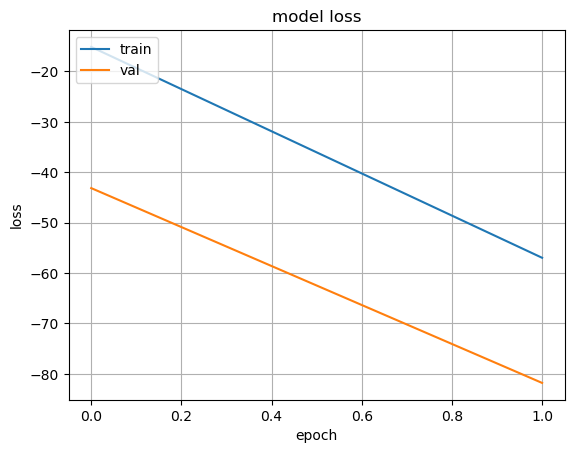

In [40]:
######################### MLP TRAINING, TO BE TUNED #########################
#***************EXTREMELY PRONE TO OVER FIT
# mlp = keras.Sequential(
#     [
#         layers.InputLayer(input_shape = (21942,)),
#         #layers.Dense(128, activation="relu"),
#         layers.Dense(32, activation="relu",kernel_initializer=initializers.RandomNormal(stddev=0.01)),
#         layers.Dropout(.25),
#         layers.Dense(1, activation='sigmoid')
#     ]
# )

mlp = keras.Sequential(
    [
        layers.InputLayer(input_shape = (21942,)),            
        layers.Dense(int(512), activation="relu"),
        #layers.Dense(int(512), activation="tanh"),  #0.6222
        #layers.Dense(int(512), activation="elu"),    #0.6227
        #layers.Dense(1, activation='sigmoid') 
        layers.Dense(1, activation='softmax') 
    ]
)

cust_adam = keras.optimizers.Adam(learning_rate = 0.0002)

mlp.summary()
mlp.compile(optimizer=cust_adam,loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
print(key_train[0])
print(key_train.shape)
print(len(key_train))
print(len(key_train[0]))
#y_train_str = [str(x) for x in y_train_kw_int]
mlp_model = mlp.fit(key_train.astype(np.float32), train_y.astype(np.float32), epochs=2,batch_size=6500,  
                     validation_data=(key_val.astype(np.float32), val_y.astype(np.float32)), verbose=1)
 
mlp.save('my_model.h5')
    
plt.plot(mlp_model.history['loss'])
plt.plot(mlp_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()



In [36]:
# i = 0
# test_set = []
# trained_model = load_model('my_model.h5')
# for ie in range(len(test)):
#     auth_counter = 0
#     venue = 999 if test.loc[ie]['venue'] == '' else test.loc[ie]['venue']
#     year = test.loc[ie]['year']
    
#     pred_max = 0.00
#     pred_auth = -1
#     for auth in range(0,100):
#         #temp_coauthors = []
#         #temp_coauthors = test.loc[ie]['coauthors']
#         #temp_coauthors.append(auth_counter)
#         temp_coauthors=[auth]
#         #print(temp_coauthors)
#         auth_counter += 1
#         #print(test.loc[ie]['coauthors'])
#         if len(temp_coauthors) >0:
#             coauthor_ohe_sum = np.sum([author_ohe_dict[author] for author in temp_coauthors if(author in author_ohe_dict)], axis = 0)
#         else:
#             coauthor_ohe_sum = np.zeros(len(author_ohe_sum))
        
#         temp = np.concatenate((coauthor_ohe_sum, year_ohe_dict[year], venue_ohe_dict[venue],abstract_train_w2v_minmax_scaled[i],title_train_w2v_minmax_scaled[i]))
#         pdd = trained_model.predict(np.asarray(temp.reshape((1, 21942))).astype(np.float32),verbose = 0)
#         #print(auth," : ",pdd[0][0])
#         if(pdd[0][0] > pred_max):
#             pred_max = pdd[0][0]
#             pred_auth = auth
#     #temp = np.concatenate((year_ohe_dict[year], coauthor_ohe_sum,author_ohe_dict[y['target']], venue_ohe_dict[venue],test_returned[i]) )
#     print(ie," -> ",pred_auth," : ",(pred_max/0.5102))
#     #test_set.append(temp)
#     i+=1

# #pdd = trained_model.predict(np.asarray(test_set).astype(np.float32))




########################################################

# i = 0
# test_set = []
# trained_model = load_model('my_model.h5')
# for ie in range(len(test)):
#     auth_counter = 0
#     venue = 999 if test.loc[ie]['venue'] == '' else test.loc[ie]['venue']
#     year = test.loc[ie]['year']
    
#     pred_max = 0.00
#     pred_auth = -1
#         if len(temp_coauthors) >0:
#             coauthor_ohe_sum = np.sum([author_ohe_dict[author] for author in temp_coauthors if(author in author_ohe_dict)], axis = 0)
#         else:
#             coauthor_ohe_sum = np.zeros(len(author_ohe_sum))
        
#         temp = np.concatenate((coauthor_ohe_sum, year_ohe_dict[year], venue_ohe_dict[venue],abstract_train_w2v_minmax_scaled[i],title_train_w2v_minmax_scaled[i]))
#         pdd = trained_model.predict(np.asarray(temp.reshape((1, 21942))).astype(np.float32),verbose = 0)

#     print(ie," -> ",pred_auth," : ",(pred_max/0.5102))

#pdd = trained_model.predict(np.asarray(test_set).astype(np.float32))


#####################################################

i = 0
test_set = []
trained_model = load_model('my_model.h5')
for ie in range(len(test)):
    auth_counter = 0
    venue = 999 if test.loc[ie]['venue'] == '' else test.loc[ie]['venue']
    year = test.loc[ie]['year']
    
    coauthor_ohe_sum = []
    if len(test.loc[ie]['coauthors']) >0:
        coauthor_ohe_sum = np.sum([author_ohe_dict[author] for author in test.loc[ie]['coauthors'] if(author in author_ohe_dict)], axis = 0)
    else:
        coauthor_ohe_sum = np.zeros(20433)
    
    temp = np.concatenate((coauthor_ohe_sum, year_ohe_dict[year], venue_ohe_dict[venue],abstract_train_w2v_minmax_scaled[i],title_train_w2v_minmax_scaled[i]))
    pdd = trained_model.predict((temp.reshape(1, 21942).astype(np.float32)),verbose = 0)
    print(ie," -> ",pdd)
    #test_set.append(temp)
    #i+=1

#pdd = trained_model.predict(np.asarray(test_set).astype(np.float32))




0  ->  [[1.]]
1  ->  [[1.]]
2  ->  [[1.]]
3  ->  [[1.]]
4  ->  [[1.]]
5  ->  [[1.]]
6  ->  [[1.]]
7  ->  [[1.]]
8  ->  [[1.]]
9  ->  [[1.]]
10  ->  [[1.]]
11  ->  [[1.]]
12  ->  [[1.]]
13  ->  [[1.]]
14  ->  [[1.]]
15  ->  [[1.]]
16  ->  [[1.]]
17  ->  [[1.]]
18  ->  [[1.]]
19  ->  [[1.]]
20  ->  [[1.]]
21  ->  [[1.]]
22  ->  [[1.]]
23  ->  [[1.]]
24  ->  [[1.]]
25  ->  [[1.]]
26  ->  [[1.]]
27  ->  [[1.]]
28  ->  [[1.]]
29  ->  [[1.]]


ValueError: zero-dimensional arrays cannot be concatenated